# Experiments on toy data

In this notebook, we conduct the same experiences as in the diabetes dataset notebook. In this notebook, we will be able to visualize the decision boundaries and thus interpret model uncertainty.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn

## Data Preprocessing

We first generate toy examples. For the data to be linearly separable and thus have easier visulization, we generate two clusters of data in a 2-dimension space. Each cluster corresponds to a class for our binary classification task.

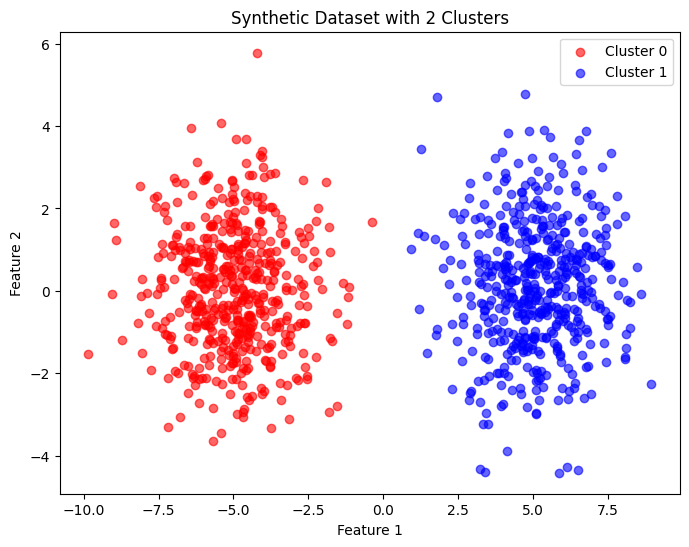

In [2]:
# Generate toy data
n_samples = 1000  
n_features = 2 
centers = [[-5, 0], [5, 0]]  # Cluster centers
cluster_std = 1.5  # Clusters std

# Creating dataset
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, 
                  cluster_std=cluster_std, random_state=42)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Cluster 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Cluster 1', alpha=0.6)
plt.title('Synthetic Dataset with 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [3]:
# We transform the np arrays to torch tensors.
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

## Model Uncertainty

In what follows, we perform the same steps as in the previous notebook.

In [4]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Initialiser le modèle
model = MLPWithDropout(input_dim=2, hidden_dims=[16], output_dim=2)

In [5]:
def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()

    return entropy

We train our model on the data

In [6]:
epochs = 100
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Run training
for epoch in range(epochs):
    model.train()  # Passer le modèle en mode entraînement
    
    # Passer toutes les données d'un coup
    output = model(X_tensor)  # Prédiction du modèle

    # Conversion de la cible en one-hot
    target_one_hot = torch.zeros(X_tensor.size(0), 2)  # 2 est pour le nombre de classes
    target_one_hot[torch.arange(X_tensor.size(0)), y_tensor] = 1  # Conversion en one-hot
    
    # Calcul de la loss
    loss = nn.BCEWithLogitsLoss()(output, target_one_hot)
    
    # Calcul des gradients et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Affichage de la loss pour chaque époque
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")


Epoch 1/100 - Loss: 0.683236
Epoch 2/100 - Loss: 0.605624
Epoch 3/100 - Loss: 0.525524
Epoch 4/100 - Loss: 0.458319
Epoch 5/100 - Loss: 0.408048
Epoch 6/100 - Loss: 0.365731
Epoch 7/100 - Loss: 0.307382
Epoch 8/100 - Loss: 0.278063
Epoch 9/100 - Loss: 0.252533
Epoch 10/100 - Loss: 0.219937
Epoch 11/100 - Loss: 0.193008
Epoch 12/100 - Loss: 0.174758
Epoch 13/100 - Loss: 0.158063
Epoch 14/100 - Loss: 0.152265
Epoch 15/100 - Loss: 0.133497
Epoch 16/100 - Loss: 0.121659
Epoch 17/100 - Loss: 0.107296
Epoch 18/100 - Loss: 0.101308
Epoch 19/100 - Loss: 0.087170
Epoch 20/100 - Loss: 0.083529
Epoch 21/100 - Loss: 0.079836
Epoch 22/100 - Loss: 0.069107
Epoch 23/100 - Loss: 0.069668
Epoch 24/100 - Loss: 0.064060
Epoch 25/100 - Loss: 0.056500
Epoch 26/100 - Loss: 0.052863
Epoch 27/100 - Loss: 0.055706
Epoch 28/100 - Loss: 0.051937
Epoch 29/100 - Loss: 0.049379
Epoch 30/100 - Loss: 0.044826
Epoch 31/100 - Loss: 0.041696
Epoch 32/100 - Loss: 0.041902
Epoch 33/100 - Loss: 0.040487
Epoch 34/100 - Loss

In [7]:
# Function to enable dropout in evaluation mode later
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

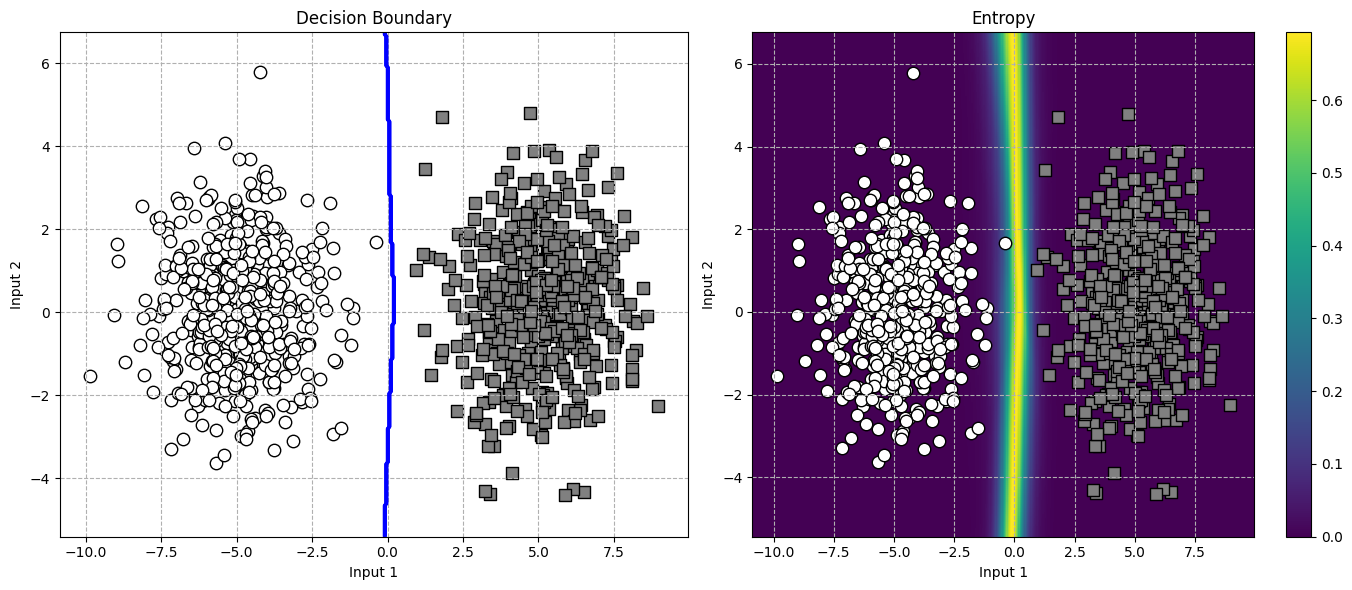

In [8]:
# Grid definition
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)


fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# Decision boundary
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel("Input 1")
ax1.set_ylabel("Input 2")
ax1.set_title("Decision Boundary")

# Entropy
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Input 1")
ax2.set_ylabel("Input 2")
ax2.set_title("Entropy")

# Evaluation mode
model.eval()


output = model(data_meshgrid)  # Logits
prob = torch.softmax(output, dim=1)  # Probas
prob_class_1 = prob[:, 1].view(xx.shape)  # Probas for class 1
entropy = get_entropy(prob_class_1) 
pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # predicted class

# Boundary decision
ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])

# Entropy plot
im = ax2.pcolormesh(xx, yy, entropy)  # Affichage de l'entropie
fig.colorbar(im, ax=ax2)


for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
    _X = X[y == label]  # Filtrer les points par classe
    ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)
    ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)

ax1.grid(linestyle="--")
ax2.grid(linestyle="--")
plt.tight_layout()
plt.show() 

tensor([[  7.4058, -10.1511],
        [ 13.9766, -16.4706],
        [ 11.9429, -18.2046],
        ...,
        [-10.7222,  17.2938],
        [-17.3075,  21.4923],
        [-29.0046,  31.3784]], grad_fn=<AddmmBackward0>)


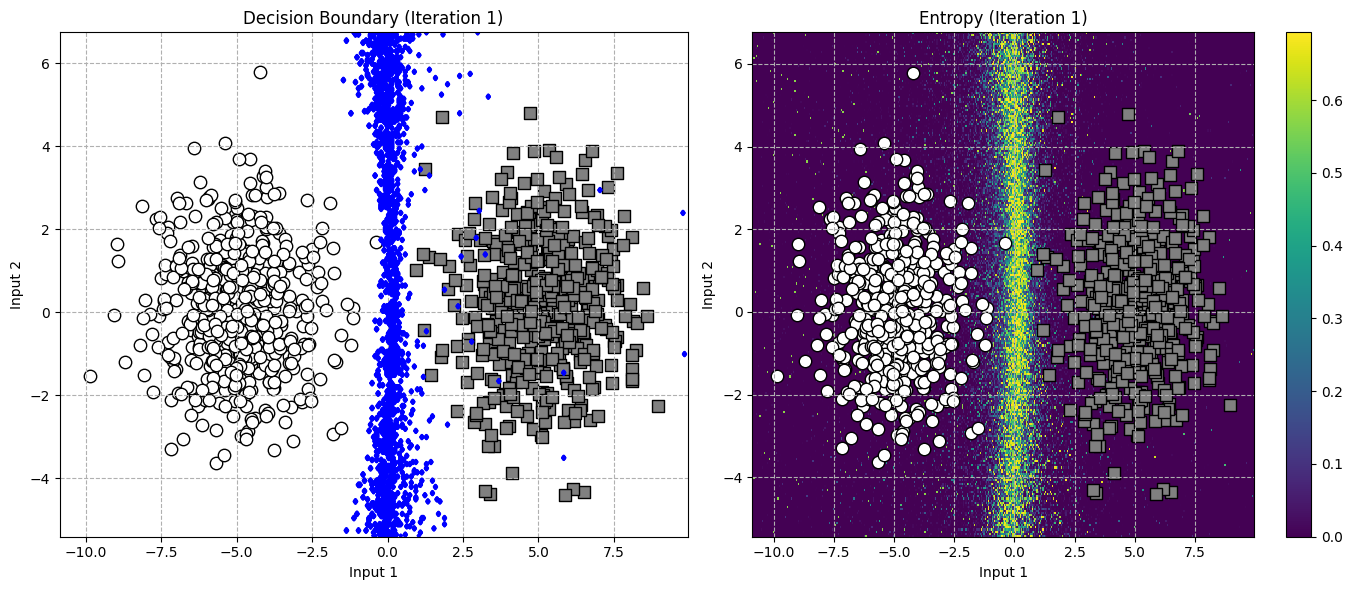

tensor([[ 23.6474, -27.3762],
        [ 18.6068, -24.6590],
        [ 12.8359, -10.0204],
        ...,
        [-22.2369,  25.6950],
        [-23.6245,  24.5178],
        [-16.6898,  21.6747]], grad_fn=<AddmmBackward0>)


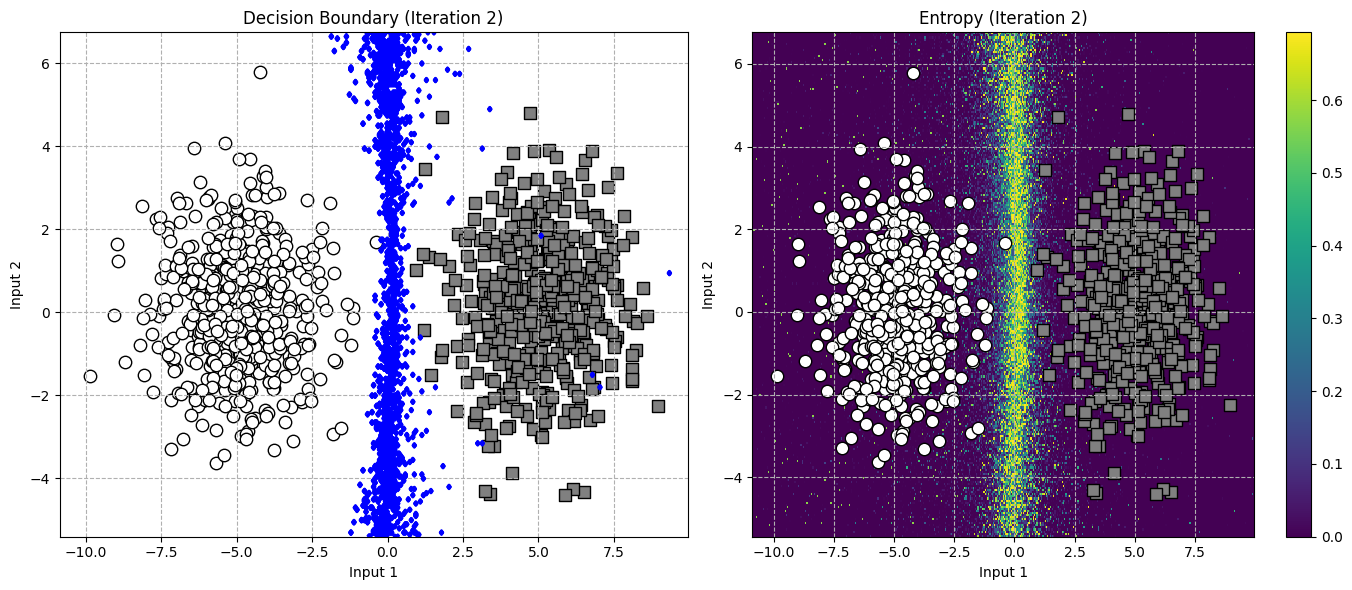

tensor([[ 22.5592, -20.9422],
        [  6.2862,  -3.6968],
        [ 19.1298, -25.8849],
        ...,
        [-33.8464,  32.6393],
        [-28.7876,  30.8583],
        [ -6.2459,  11.1289]], grad_fn=<AddmmBackward0>)


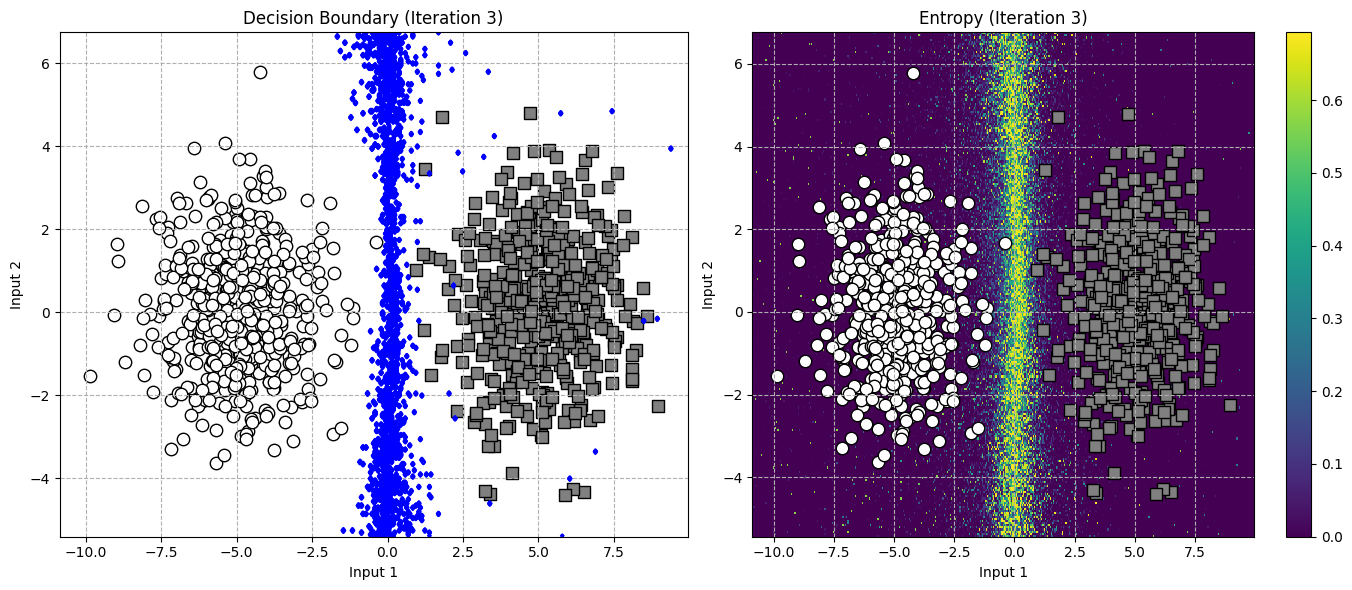

tensor([[ 12.3636, -12.7579],
        [ 14.5757, -17.8040],
        [ 18.3337, -22.6306],
        ...,
        [-29.0765,  34.4450],
        [-22.2848,  25.4661],
        [ -4.7219,   8.0041]], grad_fn=<AddmmBackward0>)


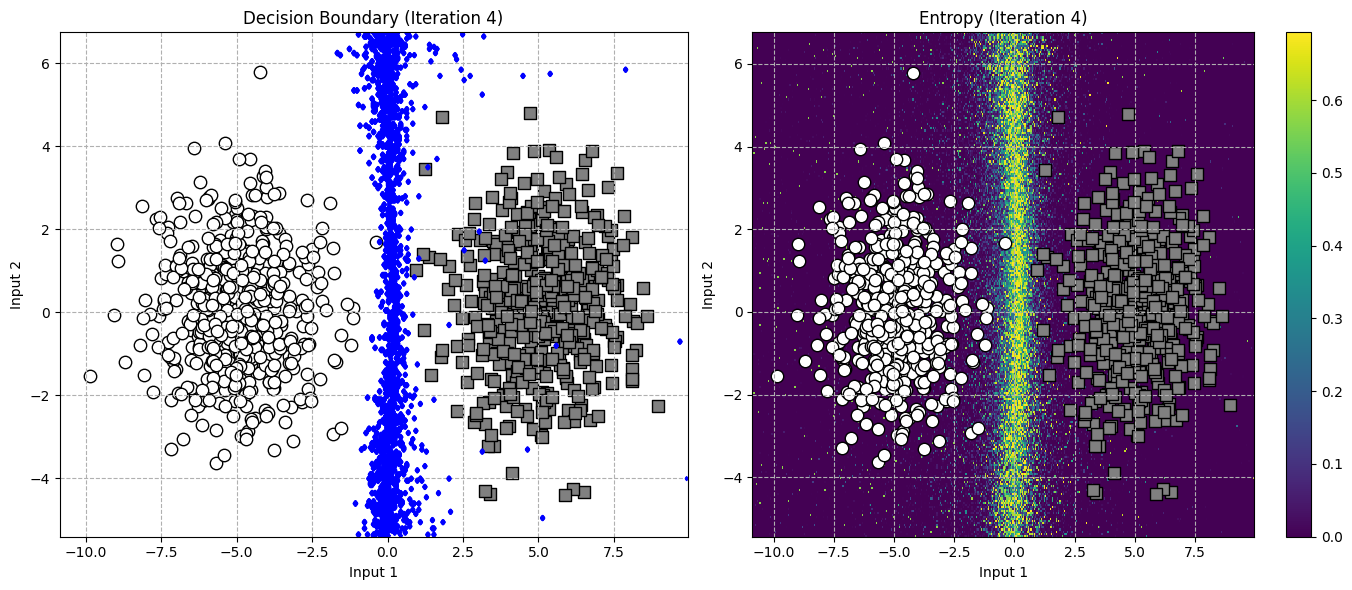

tensor([[ 24.0419, -22.7958],
        [ 18.1228, -19.5873],
        [ 13.4417, -11.3568],
        ...,
        [-11.2985,  14.8200],
        [-34.9516,  40.6577],
        [-17.5929,  22.1795]], grad_fn=<AddmmBackward0>)


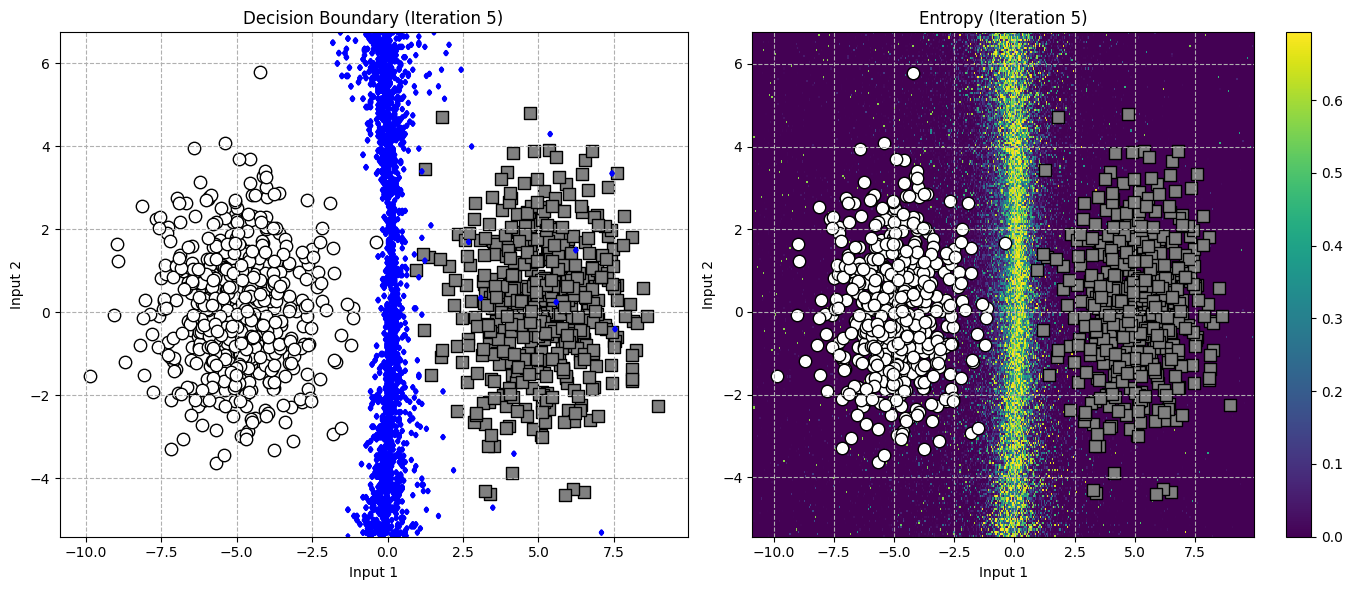

tensor([[  7.1028,  -6.9809],
        [ 22.4682, -20.8581],
        [ 14.5200, -17.7326],
        ...,
        [-16.5707,  16.5624],
        [-23.2688,  28.0155],
        [-18.6829,  25.4754]], grad_fn=<AddmmBackward0>)


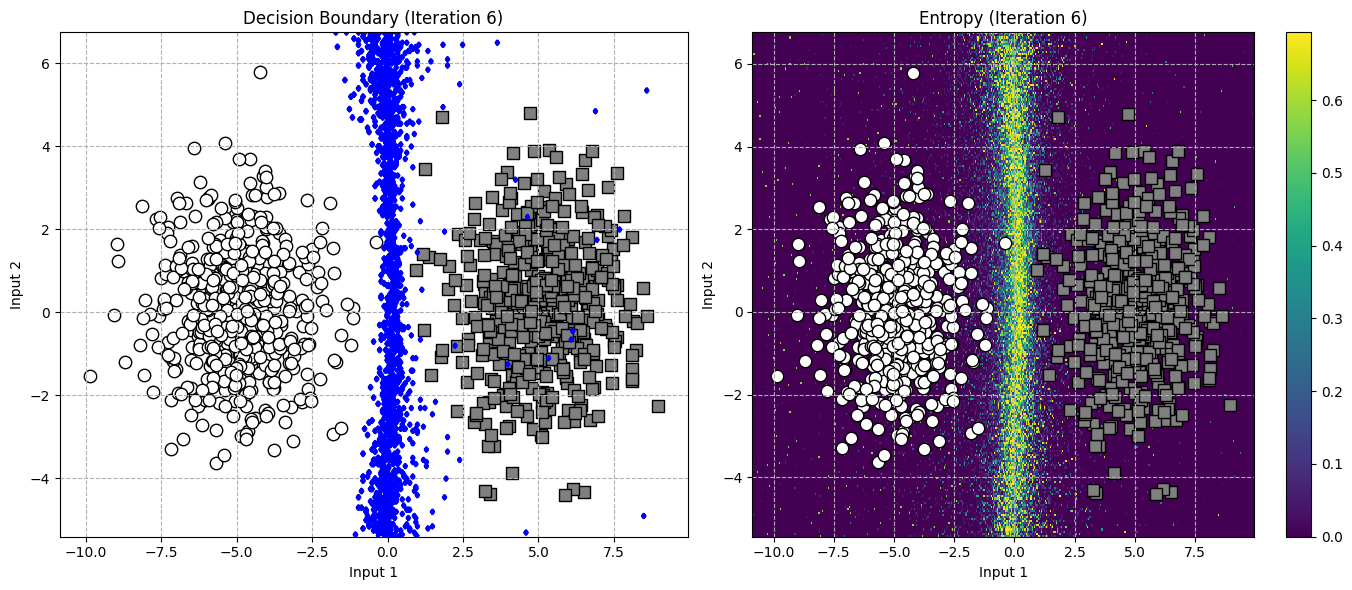

tensor([[ 17.2069, -22.9158],
        [ 18.4153, -22.7333],
        [ 18.3337, -22.6306],
        ...,
        [-23.2062,  27.8195],
        [-11.8927,  17.1803],
        [-22.7520,  23.8006]], grad_fn=<AddmmBackward0>)


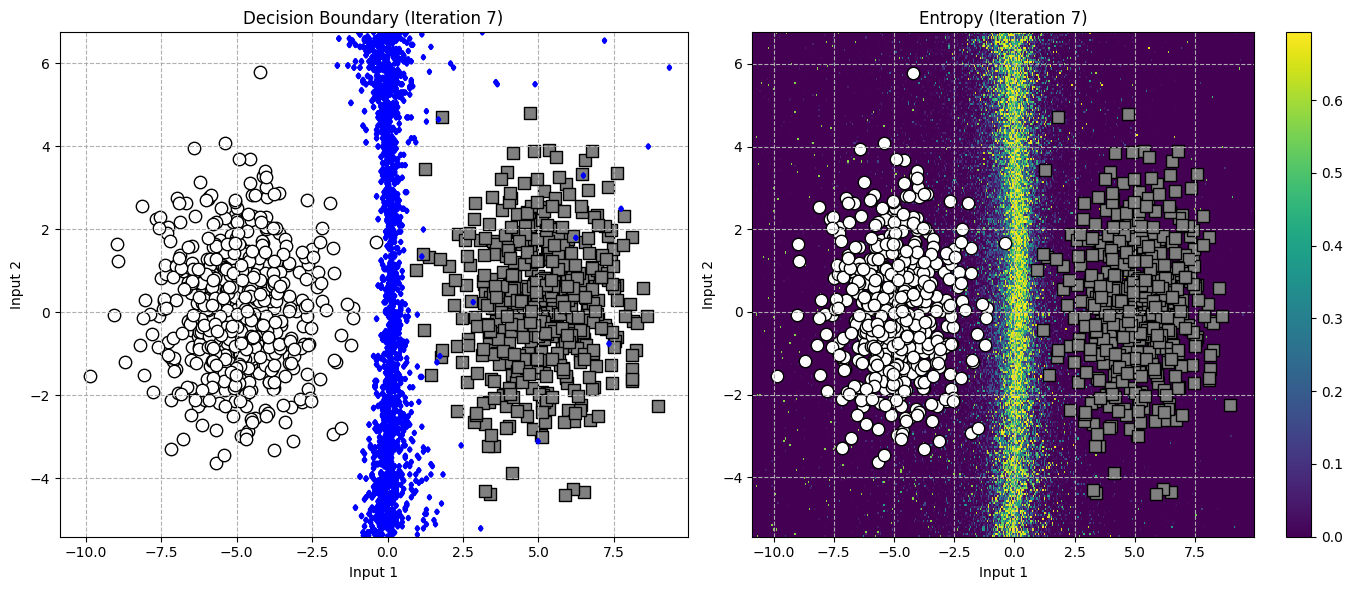

tensor([[ 18.6895, -24.7694],
        [  3.0240,  -8.8310],
        [  7.0509,  -6.9308],
        ...,
        [-12.4590,  23.1993],
        [-27.3725,  24.5731],
        [-28.8052,  28.5801]], grad_fn=<AddmmBackward0>)


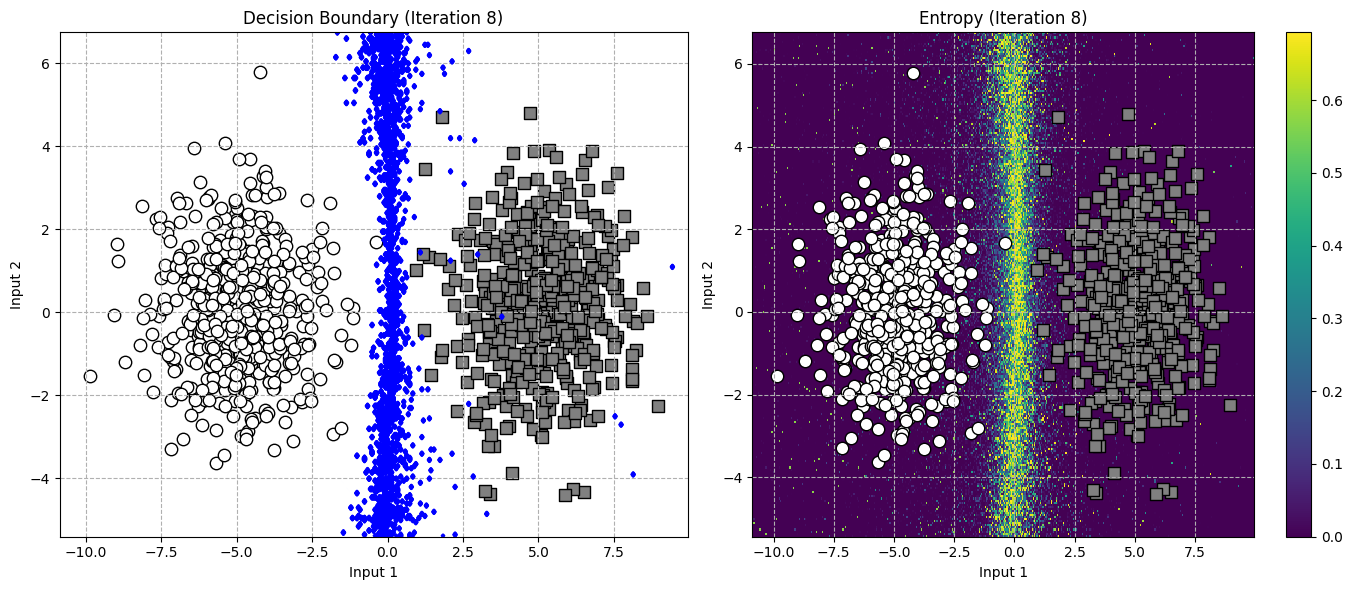

tensor([[ 25.1300, -29.2298],
        [ 20.3922, -20.9138],
        [ 17.7672, -12.6217],
        ...,
        [-17.1949,  22.6617],
        [-34.2150,  35.5873],
        [-23.1688,  27.1485]], grad_fn=<AddmmBackward0>)


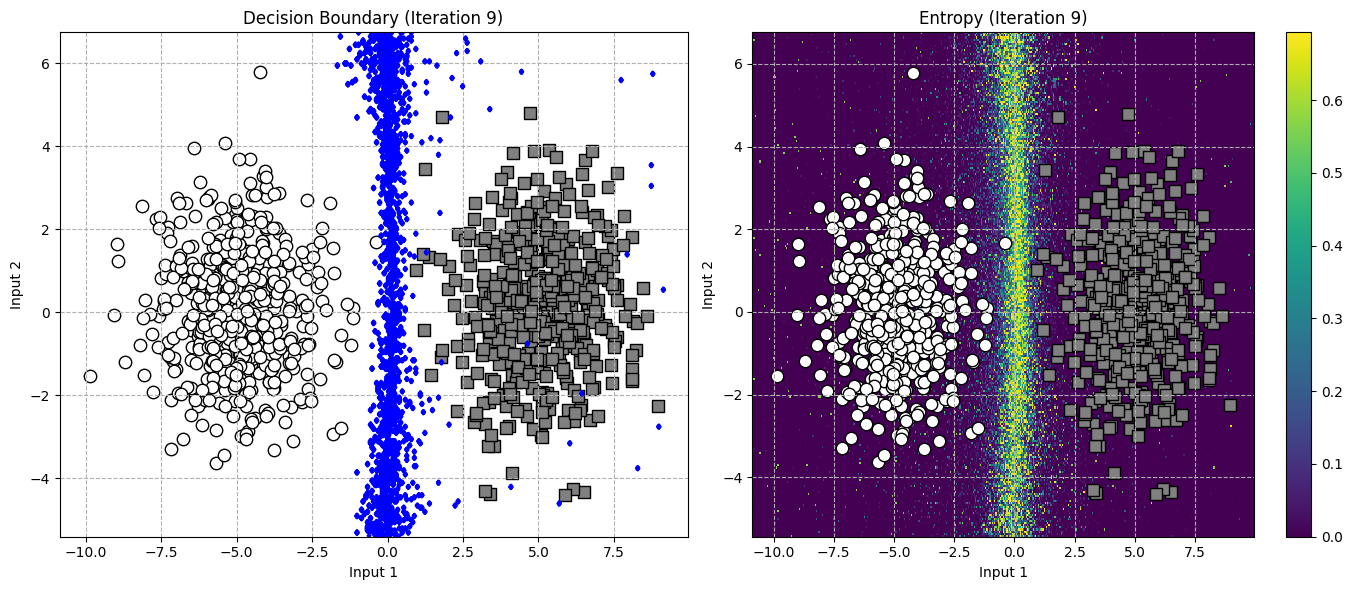

tensor([[ 24.0419, -22.7958],
        [ 23.9392, -22.6972],
        [ 18.5241, -24.5485],
        ...,
        [-12.8731,  19.5839],
        [-18.4950,  24.6273],
        [-24.1578,  28.4411]], grad_fn=<AddmmBackward0>)


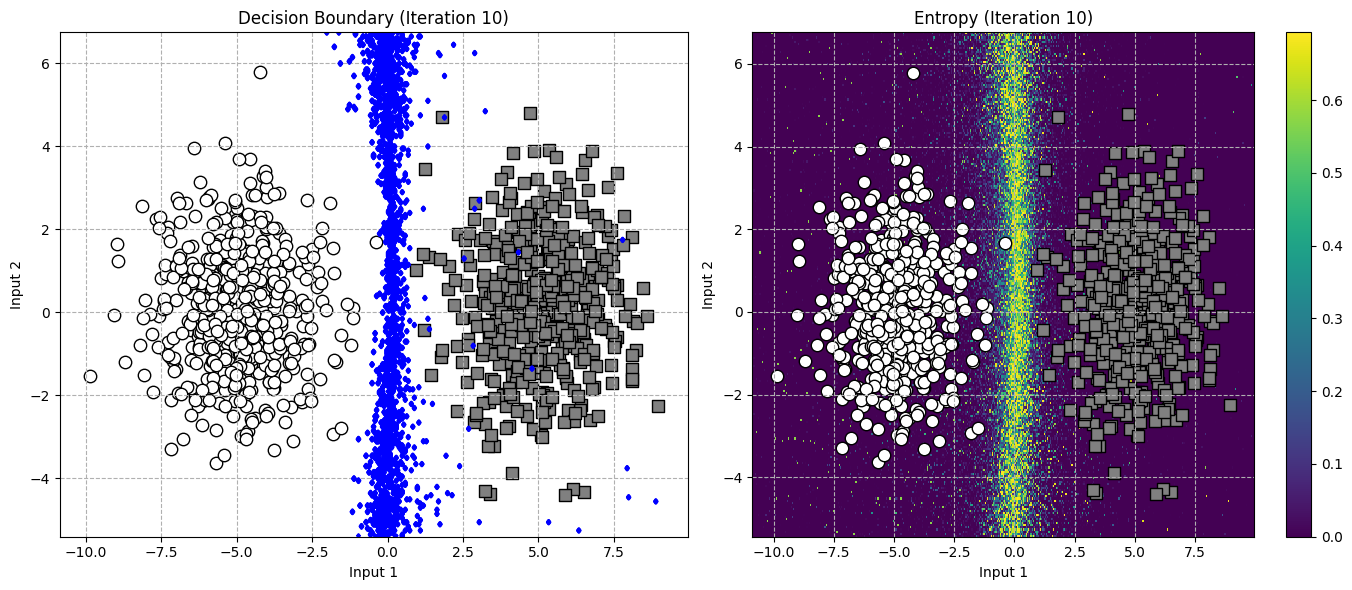

In [9]:
model.eval()
enable_dropout(model)

# Number of forward passes
num_passes = 10


for i in range(num_passes):
    output = model.forward(data_meshgrid)  # Logits
    print(output)
    prob = torch.softmax(output, dim=1)  # Probas
    prob_class_1 = prob[:, 1].view(xx.shape)  # Proba of class 1
    pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Predicted class
    entropy = get_entropy(prob_class_1)

   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Decision Boundary plot
    ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])
    ax1.set_xlabel("Input 1")
    ax1.set_ylabel("Input 2")
    ax1.set_title(f"Decision Boundary (Iteration {i + 1})")

    # Entropy plor
    im = ax2.pcolormesh(xx, yy, entropy, shading="auto")
    fig.colorbar(im, ax=ax2)
    ax2.set_xlabel("Input 1")
    ax2.set_ylabel("Input 2")
    ax2.set_title(f"Entropy (Iteration {i + 1})")

  
    for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
        _X = X[y == label]
        ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)
        ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)

    ax1.grid(linestyle="--")
    ax2.grid(linestyle="--")
    plt.tight_layout()
    plt.show() 

We observe the uncertainty across different iterations. Zones where the decision boundary is small (with respect to the 0-ordinate axis) in most iterations correspond to areas with the least uncertainty, while zones where the boundary is large indicate regions where the model is most uncertain. As shown in the entropy plot, dropout introduces some additional noise, which may cause yellow points (where the model is most uncertain) to appear in different areas of the grid as anomalies in the decision boundary, scattered across the grid. But, in these zones, it is not interpretable with uncertianity but with the noise.